<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **12. 프로젝트: 뉴스기사 요약해보기 📰**
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [ ]:
pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=131079f618ff4475f493112523f649a4f20663cb095794e210431e5ba743d9c4
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [ ]:
import nltk
nltk.download('stopwords')
from importlib_metadata import version
import nltk
import tensorflow
import summa

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__) # lms version : 3.6.5
print(tensorflow.__version__) # lms version : 2.6.0
print(version('summa')) # lms version : 1.2.0



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.7
2.8.2
1.2.0


## **Step 1. 데이터 수집하기**
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

* [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)  
아래의 코드로 데이터를 다운로드할 수 있어요.

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
summa_data = data.copy()

In [ ]:
summa_data.head() # 추출적 요약을 위한 dataframe 생성

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
data.sample(10)

,headlines,text
45222,Oscar trophies and NASA telescope are plated w...,The Oscar trophies are plated with the same go...
15569,Iran city marks war with Iraq with images of I...,The Iranian city of Shiraz commemorated the co...
5790,Goa CM should unfurl Tricolour on Goa Liberati...,Goa Pradesh Congress Committee President Giris...
98383,WhatsApp flaw to hijack accounts through image...,Check Point Security has revealed a WhatsApp v...
36222,Sidharth Malhotra to play a thug in 'Shotgun S...,"As per reports, actor Sidharth Malhotra will b..."
16573,"UAE's Emirates, Etihad airlines deny reports o...","Emirates and Etihad, two state-owned airlines ..."
81204,Plant defence mechanism makes caterpillars can...,Researchers have found a new plant defence mec...
9837,11 people killed after cyclone 'Gaja' hits Tam...,"At least 11 people were killed and 81,948 evac..."
98155,Loans to Vijay Mallya given during UPA regime:...,Minister of State for Finance Santosh Gangwar ...
63718,Photo of missing J&K cop holding an AK-47 surf...,A photo of a missing Jammu and Kashmir police ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

## **Step 2. 데이터 전처리하기 (추상적 요약)**
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.  
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습


### (1) 데이터 정리

#### 중복 샘플과 null값 존재하는 샘플 제거

In [ ]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique()) # nunique : 고유값 수 출력 / unique : 고유값 출력
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null이 이제 없네~

In [ ]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


십만개 샘플 중 2천개정도 제거됐네요~

#### 텍스트 정규화와 불용어 제거


* 같은 의미인 표현들을 묶어서 텍스트 정규화
* NLTK에서 제공하고 있는 불용어 리스트를 이용, 제거  

    [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

##### 데이터 전처리 함수 작성  
Text 전처리 시에만 불용어 제거, headline 전처리 시에는 결과문이 어색해 지지 않도록 불용어 내비둠.

In [ ]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (summary))
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [ ]:
temp_text = 'Everything I bought was great, in fact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) your day !!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great fact ordered twice third ordered wasfor mother father
summary: great way to start your day


소문자 변환, 괄호 제거, html 태그 제거, 특문 제거, 'your'과 같은 불용어 summary에서는 제거 안되게 완료!

#### 전처리 적용

전체 text 데이터에 대한 전처리를 수행합니다.

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. !!!
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

모든 headlines 데이터에 전처리를 수행해줍니다.

In [ ]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


빈 값 확인하고, 있으면 null로 대체

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [ ]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

null값이 없어요..!!! 정제 과정에서 단어가 다 제거돼서 null이 되어버린 샘플이 없다는것

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### (2) 훈련데이터와 테스트데이터 나누기

#### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


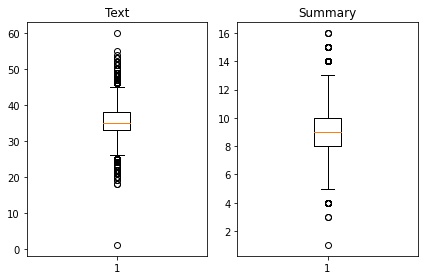

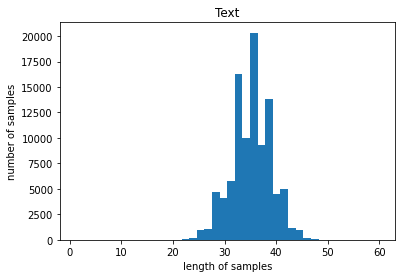

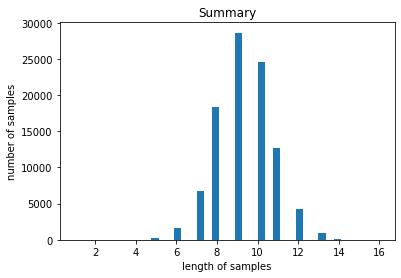

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

텍스트의 최소 길이 : 1  
텍스트의 최대 길이 : 60  
텍스트의 평균 길이 : 35.09968483123221  
요약의 최소 길이 : 1  
요약의 최대 길이 : 16  
요약의 평균 길이 : 9.299532330215534  
최소 길이와 최대 길이를 봤을 때 차이가 좀 나긴 하지만 보통 중간값에 평균이 수렴했다.  


그래프를 참고해서 적절한 최대 길이를 정해봤다.

In [ ]:
text_max_len = 40
summary_max_len = 12
print('=3')

=3


In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


90%를 넘으니 샘플 길이 소실이 적을 것 같습니다.
그러나 길이에 맞춰 자르는 것 보다 정해진 길이보다 길면 제외하도록 하겠습니다.

In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89775


전처리 후 98,360개였던 샘플이 89,775개가 되었습니다.

#### 시작 토큰과 종료 토큰 추가하기

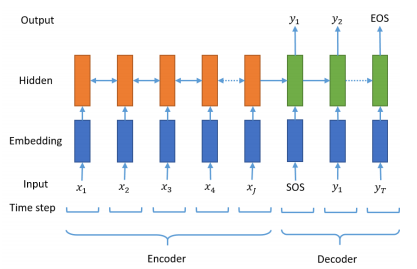

seq2seq 훈련하려면 디코더 입력, 레이블에 시작토큰, 종료토큰을 추가해야됨  
시작토큰 = sostoken 종료토큰 = eostoken 이라고 추가해보자!  
decoder_input = 디코더 입력이면서 시작토큰이 맨 앞에 있는 문장  
decoder_target = 디코더 출력 / 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙은 문장  


In [ ]:
# 요약 데이터를 이용해서 decoder_input, decoder_target을 만든당.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


인코더 입력, 디코더 입력 / 레이블 numpy 타입으로 저장

In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


#### 훈련 데이터, 테스트 데이터 분리

* 분리 패키지 사용  
* 직접 코딩을 통해 분리  <- 이거 사용

1.encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다.

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[54911 38915 46038 ... 87399  2251 44698]


2.이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


3.섞인 데이터를 8:2 비율로 분리해준다.

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17955


4.이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다. :표시의 위치에 주의!

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


훈련 데이터와 테스트 데이터가 각각 71,820개와 17,955개로 잘 분리된 것을 볼 수 있어요!

### (3) 정수 인코딩

정수인코딩 : 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 정수로 바꿔줌  
단어 집합 만들기 : 각 단어에 고유한 정수를 맵핑하는 작업  
단어 집합 만들고 -> 정수인코딩

이제는 익숙한 keras의 tokenizer로 정수인코딩을 하겠습니다.

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


src_tokenizer.word_index에 저장된 단어 집합을 확인해보겠습니다.

In [ ]:
from itertools import islice

dict(islice(src_tokenizer.word_index.items(), 10))

{'said': 1,
 'india': 2,
 'added': 3,
 'year': 4,
 'us': 5,
 'also': 6,
 'police': 7,
 'government': 8,
 'people': 9,
 'first': 10}

여기서 빈도 수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하겠습니다.  
등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼마나 비중을 차지하고 있는지 확인해볼게요.  
src_tokenizer.word_counts.items() 에는 단어와 각 단어의 등장 빈도수가 저장되어 있어요.

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65698
등장 빈도가 6번 이하인 희귀 단어의 수: 44735
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20963
단어 집합에서 희귀 단어의 비율: 68.09187494292064
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6674320594578305


등장 빈도가 6번 이하인 단어 수가 68% 정도입니다. 그러나 전체 등장 빈도에서 희귀 단어 등장 빈도 비율은 3.6% 밖에 되지 않습니다.  
그러므로 이 단어들을 모두 제거해도 된다고 판단이 되네요.  
단어집합 크기는 20000 으로 하겠습니다.

Tokenizer의 num_words 옵션에 20000을 주면 가장 빈도수가 높은 20000 - 1개의 단어가 사용됩니다.

In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


`text_to_sequences()` 를 이용해서 정수인코딩을 합니다.

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[159, 1710, 228, 2645, 759, 3315, 459, 867, 152, 286, 863, 69, 581, 1329, 1632, 1932, 8400, 6579, 6500, 7828, 1710, 526, 3786, 81, 1, 759, 1122, 4593, 120, 320, 958, 4287], [428, 2021, 16, 9814, 7590, 86, 90, 4391, 20, 882, 2877, 882, 923, 506, 3316, 541, 17386, 1095, 8253, 35, 334, 198, 17387, 12, 9, 104, 1689, 594, 763, 1810, 6931, 1999, 48, 29], [47, 2107, 144, 74, 2124, 9, 129, 872, 18417, 103, 2154, 111, 254, 2411, 1, 1568, 5514, 2148, 632, 266, 762, 3]]


요약 데이터에 대해 정수화

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


정수화가 잘 진행되었습니다.

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28844
등장 빈도가 5번 이하인 희귀 단어의 수: 18907
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9937
단어 집합에서 희귀 단어의 비율: 65.54916100402164
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.911285350744019


등장 빈도가 6번 이하인 단어 수가 65% 정도입니다. 그러나 전체 등장 빈도에서 희귀 단어 등장 빈도 비율은 5% 밖에 되지 않습니다.
그러므로 이 단어들을 모두 제거해도 된다고 판단이 되네요.  
아까 했던 것 처럼 단어집합 크기는 10000 으로 하겠습니다.

In [ ]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1863, 640, 11, 2654, 298, 866, 285, 7, 460], [1, 527, 941, 2406, 4276, 849, 11, 150], [1, 46, 3179, 127, 136, 59, 7, 153, 1083, 362], [1, 30, 811, 65, 6, 4277, 142, 7733], [1, 1453, 110, 155, 14, 145, 40, 53, 6, 1084, 5, 420, 55]]
target
decoder  [[1863, 640, 11, 2654, 298, 866, 285, 7, 460, 2], [527, 941, 2406, 4276, 849, 11, 150, 2], [46, 3179, 127, 136, 59, 7, 153, 1083, 362, 2], [30, 811, 65, 6, 4277, 142, 7733, 2], [1453, 110, 155, 14, 145, 40, 53, 6, 1084, 5, 420, 55, 2]]


빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 **빈 샘플**이 되었을 가능성이 있습니다.  
요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와서 삭제할 겁니다.  
주의할 점  
* decoder_input에는 시작토큰, decoder_target에는 종료토큰이 추가된 상태. 모든 샘플에서 등장하니까 빈도수가 높아서 삭제되지 않았을 것이다. 그래서 실제로 길이가 0이 된 요약문이지만 출력은 1로 나올 것

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17955
테스트 레이블의 개수 : 17955


문장 길이가 1인 데이터가 한개도 없네요! 

### (4) 패딩하기

아까 정해뒀던 maxlen을 이용해서 패딩해줍니다!!

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


전처리 완료~

## **Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)**
일반적인 seq2seq보다는 **어텐션 메커니즘**을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

어텐션 메커니즘  
* 기존의 seq2seq는 인코더의 마지막 time step의 은닉층을 컨텍스트 벡터로 사용  
    * BUT, RNN 계열의 인공신경망(바닐라 RNN, LSTM, GRU) 의 한계로 이 컨텍스트 정보에는 이미 입력 시퀀스의 많은 정보가 손실이 된 상태
* 어텐션은 인코더의 **모든 step의 은닉층 정보가 컨텍스트 벡터에 전부 반영**되도록 하는것
* 모든 은닉층이 동일한 비중으로 반영되는 건 아니고, **디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지**에 따른 가중합으로 계산
* 주의) 컨텍스트 벡터를 구성하기 위한 인코더 은닉층의 가중치값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라짐. 디코더의 현재 문장 생성 부위가 술어부인지 목적어인지에 따라 인코더가 입력 데이터를 해석한 컨텍스트 벡터가 다른 값이 됨.
* 디코더의 현재 스텝에 따라 동적으로 달라지는 인코더의 컨텍스트 벡터를 사용, 현재의 예측에 활용하면 디코더가 좀 더 정확한 예측을 할 수 있다.

흐름도
1. seq2seq를 사용합니다.
2. RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
3. 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
4. seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
5. seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
6. 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

### seq2seq 모델 설계하기

인코더 설계

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터 차원
hidden_size = 256 
# 은닉층 크기 LSTM에서 얼마만큼의 capacity를 가질지? 
# LSTM 용량 크기/LSTM 뉴런 개수 / 크다고 성능이 올라가는 건 아님

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
#encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
#encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
#encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 일반 dropout : 레이어의 가중치를 랜덤으로 생략하여 모델의 과적합 해결
* recurrent dropout : dropout을 레이어가 아닌 **time step마다 해주는** 방식. time step의 입력을 랜덤으로 생략. recurrent dropout은 일반적인 dropout과 같이 regularization 해주는 효과가 있고, 과적합 방지.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

디코더의 출력층을 설계해볼게요.

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있어요.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq에요. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있어요! 바로 어텐션 메커니즘이에요.

## 어텐션 메커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.



In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.

### 모델 훈련하기

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
281/281 [==============================] - 181s 588ms/step - loss: 5.6503 - val_loss: 5.2178
Epoch 2/50
281/281 [==============================] - 164s 585ms/step - loss: 5.0884 - val_loss: 4.8419
Epoch 3/50
281/281 [==============================] - 164s 585ms/step - loss: 4.7546 - val_loss: 4.6007
Epoch 4/50
281/281 [==============================] - 164s 584ms/step - loss: 4.5009 - val_loss: 4.4168
Epoch 5/50
281/281 [==============================] - 164s 583ms/step - loss: 4.2978 - val_loss: 4.2852
Epoch 6/50
281/281 [==============================] - 164s 583ms/step - loss: 4.1287 - val_loss: 4.1750
Epoch 7/50
281/281 [==============================] - 163s 579ms/step - loss: 3.9817 - val_loss: 4.1006
Epoch 8/50
281/281 [==============================] - 163s 581ms/step - loss: 3.8567 - val_loss: 4.0239
Epoch 9/50
281/281 [==============================] - 163s 580ms/step - loss: 3.7426 - val_loss: 3.9666
Epoch 10/50
281/281 [==============================] - 163s 579m

1시간 걸림;

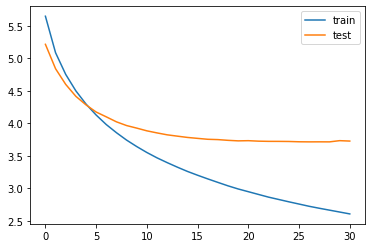

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## **Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)**
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 **정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작**해야 하기 때문에 부득이하게 **인퍼런스를 위한 모델 설계를 별도로** 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.



In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.



In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


### 12-11. 모델 테스트하기
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : world fourth richest person warren buffett said buying bitcoin investment gamble buy something like bitcoin cryptocurrency really anything produced anything hoping next guy pays billionaire added buffett earlier said cryptocurrencies come bad ending 
실제 요약 : buying bitcoin not investment billionaire buffett 
예측 요약 :  cryptocurrencies are not valuable cryptocurrency warren buffett


원문 : around residents us state florida pledged point fans direction hurricane irma attempt blow away part event created facebook category storm caused one largest evacuations us history also one strongest atlantic hurricanes 
실제 요약 : people to try away hurricane irma with fans 
예측 요약 :  us city hurricane hit by us volcano


원문 : congress tuesday claimed bjp bjd share secret ties adding simply trying fool people odisha pm cm betrayed people statement came prime minister narendra modi criticised odisha government without directly mentioning patnaik bjd 
실제 요약 : pm speech exposes secret ties between bjp bj

정확도가 많이 떨어집니다.  
성능 개선 방안  
* seq2seq와 어텐션 자체의 조합을 더 좋게 수정
* 빔 서치(beam search)
* 사전 훈련된 워드 임베딩(pre-trained word embedding)
* 인코더-디코더 자체의 구조를 새로이 변경한 트랜스포머(transformer)

## **Step 5. Summa을 이용해서 추출적 요약해보기**
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.  
(추출적 요약을 하는 경우에는 오직 text열만을 사용)  
Summa의 summarize를 사용하여 추출적 요약을 해보세요.

# 12-12. 추출적 요약 해보기
패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있어요.


## 데이터 다운로드하기

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
summa_data.sample(10)

,headlines,text
9141,IndiGo's ex-Chief Commercial Officer joins Air...,AirAsia India has appointed IndiGo's former Ch...
66168,"Lord Brahma should be saluted here, not me: Ra...",Refusing to take the holy seat of Lord Brahma ...
96965,Startup offers shares to investors who promise...,"One-drop blood test company Theranos, which wa..."
36977,Iran will face wrath of entire world if it pur...,Warning Iran against pursuing its nuclear prog...
7039,Italy regulator fines Facebook $11 mn for sell...,Italian Competition Authority has imposed two ...
68075,US lawmakers to discuss backing India's UNSC m...,Two US Congressmen have introduced a resolutio...
7866,Most encounters in Uttar Pradesh are fake: Ex-...,Former Uttar Pradesh CM Akhilesh Yadav has sai...
52733,Cop suspended for sharing morphed pic of PM Mo...,A 57-year-old Bihar Police Inspector has been ...
9005,Will consult churches on liquor policy if Cong...,Mizoram CM Lal Thanhawla on Thursday said the ...
34303,Cong committed suicide by moving impeachment n...,After Rajya Sabha Chairman Venkaiah Naidu reje...


In [ ]:
summa_data['extract'] = summa_data.text.apply(lambda x : summarize(x, ratio=0.005))

In [ ]:
summa_data.head()

,headlines,text,extract
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,


왜안되지

In [ ]:
text = summa_data['text']


In [ ]:
summa_data['extract'] = summa_data.text.apply(lambda x : summarize(x, ratio=0.4))

In [ ]:
summa_data.head()


,headlines,text,extract
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


In [ ]:
for idx, (head, text) in enumerate(zip(summa_data['headlines'], summa_data['text'])):
    if idx == 50:
        break   
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.40))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

요약 결과가 나오지 않은 부분이 있었지만, 그래도 의미가 통하는 요약이 꽤 나왔습니다.

---

## **추상적 요약과 추출적 요약의 결과 비교**

## 추상적 요약  
원문 : around residents us state florida pledged point fans direction hurricane irma attempt blow away part event created facebook category storm caused one largest evacuations us history also one strongest atlantic hurricanes   
실제 요약 : people to try away hurricane irma with fans   
예측 요약 :  us city hurricane hit by us volcano  
**문법적으로는 맞지 않지만 의미적으로는 비슷한 내용이 나왔습니다. 다만 조금 이상한 내용은 원문에서 나오지 않는 'volcano'가 나왔다는 것입니다! 여러 기사를 학습하다 보니 volcano에 의해 대피하는 것과 허리케인에 의해 대피하는 것에 유사함을 느꼈나 봅니다.**

원문 : rape accused producer harvey weinstein reportedly refused take picture man named steve restaurant slapped called piece sh reports said steve appeared drunk approached weinstein video surfaced online steve heard saying weinstein get ck   
실제 요약 : man slaps rape accused weinstein calls him piece of sh   
예측 요약 :  harvey weinstein claims accused of sexual assault  
**비록 핵심 내용은 아니지만 문장 서두에 있는 'harvey weinstein이 강간 혐의로 기소되었다' 는 내용이 올바른 문법으로 요약되었습니다.**

원문 : fire broke dubai storey residential building tiger tower sunday however fire quickly extinguished injuries reported incident improperly disposed cigarette high temperatures could blaze officials said comes blaze struck dubai storey torch tower one world tallest residential towers friday   
실제 요약 : dubai storey residential building catches fire   
예측 요약 :  fire breaks out at mumbai highway office  
**불이 났다고 잘 요약했는데 문제는 두바이-> 뭄바이로 잘못 학습했다는 겁니다. 그리고 highway office는 굉장히 어색합니다.**

## 추출적 요약  

원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. **Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.**  
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED  
추출적 요약 : **Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.**  

**마지막 문장을 그대로 복사 붙여넣기 했네요? 앞쪽에 주제가 있는데 잘못 요약했습니다.** 인줄 알았는데...

---

원문 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. **The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.**  
실제 요약 : New Zealand end Rohit Sharma-led India's 12-match winning streak  
추출적 요약 : **The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.**


원문 : With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. **Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.**    
실제 요약 : Aegon life iTerm insurance plan helps customers save tax   
추출적 요약 : **Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.**  


원문 : **Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.** But in this case, we need to reserve our judgment," she added. Hirani has been accused by an assistant who worked in 'Sanju'.  
실제 요약 : Have known Hirani for yrs, what if MeToo claims are not true: Sonam    
추출적 요약 : **Speaking about the sexual harassment allegations against   Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "In the #MeToo movement, I always believe a woman.**    


원문 : **Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.** "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre".  
실제 요약 : Rahat Fateh Ali Khan denies getting notice for smuggling currency    
추출적 요약 : **Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.**   

---

그냥 추출적 요약은 기사의 앞이나 뒤에 있는 문장을 고대로 가져옵니다. 문법적으로는 절대 틀릴 수 없겠죠. 그러나 엉뚱한 문장을 가져오는 경우도 있어서 좋아보이지는 않습니다. 
아마 ratio를 0.4로 줘서 더 원문에서 가져온 문장의 비율이 높았을 것 같습니다. ratio를 적절하게 조절한다면 더 나은 결과를 낼 수 있겠습니다.
 

## 🌮 루브릭
| **평가문항** | **상세기준** | **성취결과** |
|---|---|:---:|
| 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. | 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다. | O |
| 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다. | 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다. | O |
| 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. | 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다. | O |

## ✍ 회고

* 모델 학습 너무 오래걸린다. 어쩌다 런타임 끊기기라도 하면 패키지 다시 설치하고, 전처리 하고, 모델 학습까지 돌리면 1시간은 족히 소요됨. 너무 슬프다.. 내주말..  
    * 그래서 더 여러가지 시도를 주저하게 됐다. 한개 바꿔야되는데 런타임 초기화 되어있는 상태면 ... (생략)

* 추출적 요약 사용해보는데 튜토리얼과 같은 방식으로 하면 너무 오래걸려서 결과가 안나오고(1시간돌림), lambda로 데이터프레임 자체에 함수를 맥이면 요약이 출력되지 않았다.  
    무엇이 잘못된 것일ㄲㅏ..?  
    * 전처리 되기 전 원본 문장을 사용해야 한다고 함..! 
    * 그렇게 했는데도 안나오는데요..? 두시간돌림 뭐가 잘못된걸까나
    * dataframe을 실습때 했던 매트릭스 시놉시스랑 같은 폼으로 만들어야 될 것 같아서 tolist를 통해 list로 바꾸고, \n를 추가했었는데, 그래서 안된듯. 


* 영자신문 특성상, 약어가 많이 나와서 학습에 어려움을 겪었을 수도 있다는 생각이 들었다. prime minister : PM 처럼~

* 앞서 기술되어있었지만 추상적 요약의 모델 설계에서 저번에 배운 사전 훈련된 워드 임베딩을 사용해 학습시키면 더 잘 될 것 같다! 

* 추상적 요약에서 놀라웠던 점은 추출적 요약과는 비교되게 paraphrasing 된 표현이 요약된 문장에서 발견되었다는 것이다. 장점이지만 단점으로 작용될 수 있는게 원문의 맥락과 차이날 수 있는 표현도 사용이 되었기 때문에 주의할 필요가 있어보인다. 이 부분은 더 많은 데이터로 학습을 시켜준다면 모델이 충분히 학습할 수 있다고 생각된다.

### 참고문헌

[SettingWithCopy Warning or Error](https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221817400937)